# Pythonによる画像解析ノート Vol. 3

In [28]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

## モルフォロジー変換
2値化画像を対象とした処理、ノイズの除去に有効。    
収縮 erosion 白の領域が収縮する  
膨張 dilation 白の領域が膨張する  
オープニング opening、収縮の後に膨張、背景中のノイズ除去に有効  
クロージング closing、膨張の後に収縮、対象の中の比較的小さな黒い穴を埋めるのに有効

<class 'numpy.ndarray'>
(38924,)


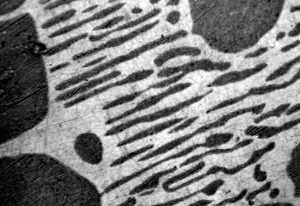

<class 'numpy.ndarray'>
(45300,)


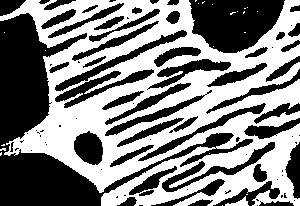

In [29]:
aupb = cv2.imread("images/AuPbSn40.tif", 0)
# 画像の高さと幅を取得
h, w = aupb.shape
# 拡大率
mag = 2
# 画像が大きいので縮小しておく
aupb = cv2.resize(aupb, (w//mag, h//mag)) # 2で割った商
ret, aupb_bin = cv2.threshold(aupb, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show(aupb)
show(aupb_bin)

<class 'numpy.ndarray'>
(44514,)


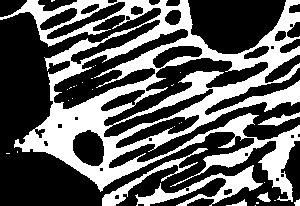

<class 'numpy.ndarray'>
(38544,)


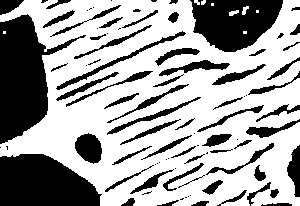

In [30]:
kernel = np.ones((3,3),np.uint8) # 全ての要素が1の3x3のカーネル
# kernel = np.ones((5,5),np.uint8) # 全ての要素が1の5x5のカーネル
erosion = cv2.erode(aupb_bin,kernel,iterations = 1)
dilation = cv2.dilate(aupb_bin,kernel,iterations = 1)
show(erosion)
show(dilation)

<class 'numpy.ndarray'>
(43651,)


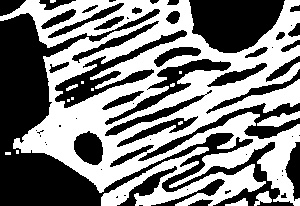

<class 'numpy.ndarray'>
(42128,)


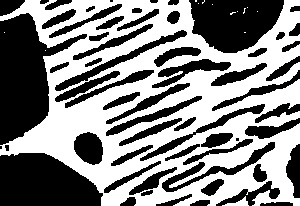

In [31]:
opening = cv2.morphologyEx(aupb_bin, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(aupb_bin, cv2.MORPH_CLOSE, kernel)
show(opening)
show(closing)

#### Scipyを使うやり方
カーネルを設定する必要が無く、iterationを設定できる。こちらの方がImageJ/FIJIでの方法に近い？

<class 'numpy.ndarray'>
(45465,)


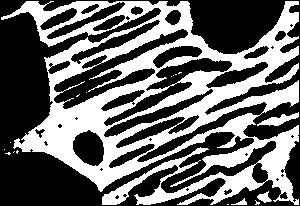

<class 'numpy.ndarray'>
(22927,)


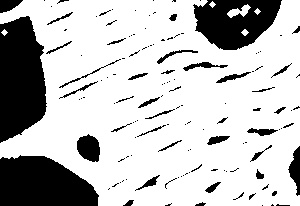

In [32]:
from scipy import ndimage
erosion2 = ndimage.binary_erosion(aupb_bin).astype(aupb_bin.dtype)
dialation2 = ndimage.binary_dilation(aupb_bin, iterations= 3).astype(aupb_bin.dtype)
show(erosion2*255)
show(dialation2*255)

In [ ]:
opening2 = ndimage.binary_opening(aupb_bin).astype(int)
closing2 = ndimage.binary_dilation(aupb_bin).astype(int)
show(opening2*255)
show(closing2*255)

#### Scipy以外にもscikit-image.morphologyでモルフォロジー変換が可能  
#### skimage.morphologyではiterationではなく、footprintを設定するので注意

#### Fill holes  
対象の中に空いた穴（ピクセル値0）を埋める（1に置換）する操作

In [ ]:
from scipy import ndimage
filled = ndimage.binary_fill_holes(aupb_bin).astype(int)
show(filled*255)

#### モルフォロジー勾配  
膨張した画像と収縮した画像の差分をとる処理、結果として物体の外郭(境界線)が得られる

In [ ]:
kernel = np.ones((3,3),np.uint8) # 全ての要素が1の3x3のカーネル
gradient = cv2.morphologyEx(aupb_bin, cv2.MORPH_GRADIENT, kernel)
gradient2 = ndimage.morphological_gradient(aupb_bin, size=(3,3))
show(gradient)
show(gradient2)

## 対象の検出
2値化画像を使用して、黒い背景から白い解析対象を検出すると仮定。ImageJ/FIJIの`Analyze Particels`コマンドに相当する。  
2値化画像において白（1）が繋がっている領域のことをブロブ（blob）と言うが、各ブロブの画素に対して、同じ番号（ラベル）を順に与えていく操作がラベリング（labeling）。  
ラベリングには、2値化された画像の縦、横方向に連続している部分を同じラベルにする４連結と、縦、横、斜め方向に連続している部分を同じラベルにする８連結との２種類の処理がある
（４近傍、８近傍という場合もある）。 https://imagingsolution.net/imaging/labelling/  

ブロブのラベリングには`cv2.connectedComponents()`関数を使い、ラベル化した画像とともにブロブの面積や重心がわかる。  
ブロブの周囲長や外接円等が知りたい場合は、輪郭処理ベースの`cv2.findContours()`関数を使用する。
https://imagingsolution.net/program/python/opencv-python/connectedcomponents/

<class 'numpy.ndarray'>
(11821,)


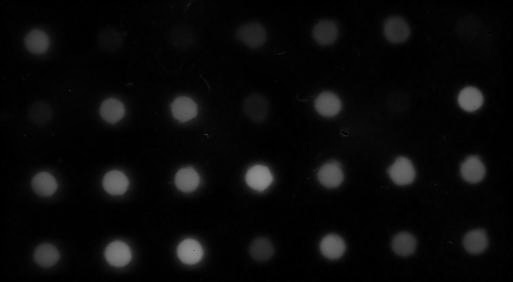

<class 'numpy.ndarray'>
(19778,)


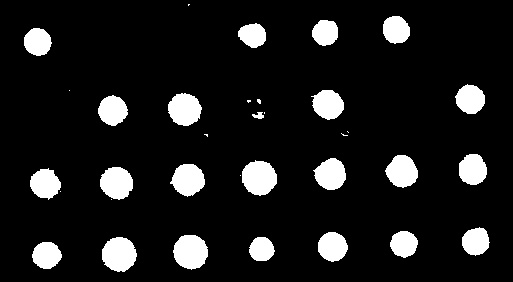

In [27]:
dots = cv2.imread("images/Dot_Blot.tif", 0)
dots = ~dots # pixel値が反転する
from cv2_rolling_ball import subtract_background_rolling_ball
dots_bg, _ = subtract_background_rolling_ball(dots, 100, light_background=False,
                                     use_paraboloid=False, do_presmooth=False)
show(dots_bg)
ret, dots_bin = cv2.threshold(dots, 20, 255, cv2.THRESH_BINARY)
show(dots_bin)

<class 'numpy.ndarray'>
(19028,)


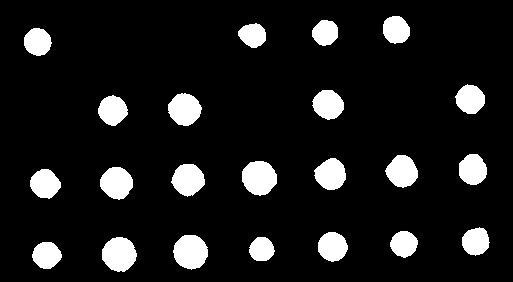

In [46]:
opening = ndimage.binary_opening(dots_bin, iterations=3).astype("uint8")
show(opening*255)

23


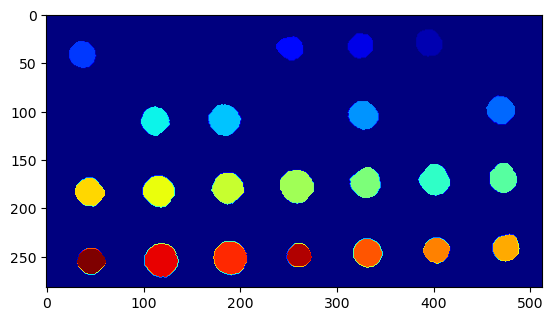

In [56]:
""" ラベリング
入力画像は8-bit 1chである必要がある、引数connectivityで4または8連結を指定することも可能
retval: ラベルの個数、ただし背景も1つとしてカウント
labels: ラベリング結果のndarray
stats: 各ブロブの情報 [左上x, 左上y, 領域の幅、領域の高さ、面積]
centroids: 各ブロブの重心
"""
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(opening)
print(retval)
plt.imshow(labels, cmap = "jet")

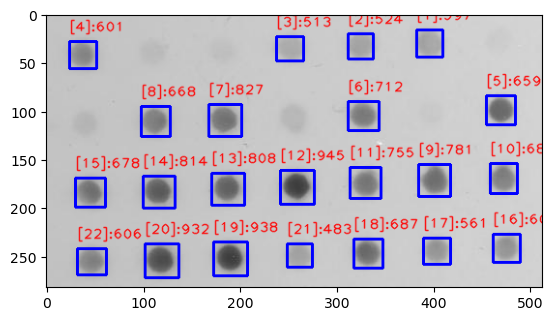

In [52]:
# 結果の表示
dots_rgb = cv2.imread("images/Dot_Blot.tif", 1) # 画像表示用に入力画像をカラーデータに変換する
for i in range(1, retval):
    x, y, width, height, area = stats[i] # x座標, y座標, 幅, 高さ, 面積
    cv2.rectangle(dots_rgb,(x,y),(x+width,y+height),(0,0,255),2)
    cv2.putText(dots_rgb, f"[{i}]:{area}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1, cv2.LINE_AA)
plt.imshow(dots_rgb)

Scikit-imageを使用するやり方

22


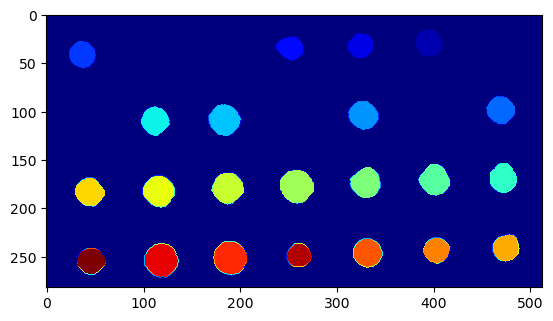

In [55]:
from skimage import measure
labels, num = measure.label(opening, return_num=True) # Trueにするとラベルの個数を表すnumが返ってくる、背景はカウントしない
print(num)
plt.imshow(labels, cmap = "jet")

元の画像にラベルをカラーで重ねる場合

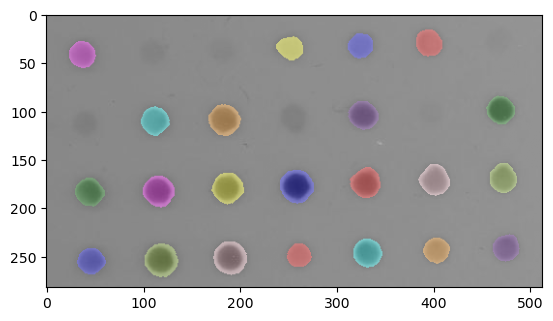

In [59]:
from skimage.color import label2rgb
dots_rgb = cv2.imread("images/Dot_Blot.tif", 1) # 画像表示用に入力画像をカラーデータに変換する
label_overlay = label2rgb(labels, image = dots_rgb, bg_label = 0)
plt.imshow(label_overlay)